In [ ]:
# Mouting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import datetime
import gc
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import *
from keras.models import Sequential, Model, load_model
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.math import confusion_matrix

%load_ext tensorboard

In [ ]:
batchSize = 32
imageHeight = 180
imageWidth = 180
randomisingSeed = 108
colorMode = "rgb"
validationSplitFraction = 0.2
imageInterpolationMethod  = "bilinear"
cropToPreserveAspectRatioWhileResizing = False

augmentDataset = True
cropBottomPanel = False

earlyStoppingMetric = "val_accuracy"
earlyStoppingMinimumImprovementCriterion = 0.005
earlyStoppingPatience = 30

baselineAccuracy = 0.5

learningRateReductionMetric = 'val_loss'
patienceForLearningRateReduction = 10
learningRateReductionFactor = 0.1
learningRateReductionMinimumImprovementCriterion = 0.0001
learningRateReductionCooldown = 25
minimumLearningRate = 0

useTensorboard = False

useArchitecture = ['customCNN', 'ResNetTransfer'][1]
doSeperateFineTuning = True
makeTransferModelTrainable = False
addConvolutionLayersOnBaseModel = True

maxPoolingSize = (2, 2)
maxPollingPadding = 'valid'

convolutionKernelSize = 3
convolutionKernelRegulariser = None
convolutionActivityRegulariser = None

In [ ]:
# Daatset locations on G drive
# Make sure that the daatset folder is there in drive
# And that a seeprate tmpModelBackup folder has been created for each model that runs at a given time
datasetName = 'SEM100'
modelName = 'Resnet_finetunedAfterTraining_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefault'
trainingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/train'
testingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/test'
historySaveLocation = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/history/' + modelName + 'data.pickle'
fineTuneHistorySaveLocation = '/content/drive/My Drive/' + datasetName + '/models/history/' + modelName + '_fineTune_data.pickle'
modelSaveLocation = '/content/drive/MyDrive/SEMProject/SEM100/models/finalModels/' + modelName + '.h5'
fineTuneModelSaveLocation = '/content/drive/MyDrive/SEMProject/SEM100/models/finalModels/' + modelName + '_fineTune.h5'

In [ ]:
def getDataset(batchSize, imageHeight, imageWidth, randomisingSeed, colorMode, validationSplitFraction, imageInterpolationMethod, cropToPreserveAspectRatioWhileResizing, augmentDataset, cropBottomPanel):
  trainingDataset, validationDataset = tf.keras.utils.image_dataset_from_directory(
      directory = trainingDataPath,
      labels = "inferred",
      label_mode = "categorical",
      color_mode = colorMode,
      batch_size = batchSize,
      image_size = (imageHeight, imageWidth),
      seed = randomisingSeed,
      shuffle = True,
      validation_split = validationSplitFraction,
      subset="both",
      interpolation = imageInterpolationMethod,
      crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
      )

  testingDataset = tf.keras.utils.image_dataset_from_directory(
    directory = testingDataPath,
    labels = 'inferred',
    label_mode = "categorical",
    color_mode = colorMode,
    batch_size = batchSize,
    image_size = (imageHeight, imageWidth),
    seed=  randomisingSeed,
    shuffle = True,
    interpolation = imageInterpolationMethod,
    crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
    )

  classNames = np.array(trainingDataset.class_names)
  print(classNames)

  def cropBottomPanel(image, label):
    return tf.image.crop_and_resize(image = image , boxes = np.array( [[0, 0, 600/768, 1]] ) ,box_indices = [0], crop_size = (imageHeight, imageWidth), method = imageInterpolationMethod,extrapolation_value = 0.0,name = None), label

  #if cropBottomPanel:
    #trainingDataset = trainingDataset.map(cropBottomPanel)
    #validationDataset = validationDataset.map(cropBottomPanel)
    #testingDataset = testingDataset.map(cropBottomPanel)
    #imageHeight = int(imageHeight * 600/ 768)

  augmentedTrainingDataset = trainingDataset

  if augmentDataset:
    dataAugmentation = keras.Sequential(
        [
            layers.RandomRotation(factor = (-0.5, 0.5), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomFlip(mode = "horizontal_and_vertical", seed = randomisingSeed),
            layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomZoom(height_factor = (-0.3, 0.3), width_factor = (-0.2, 0.2), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomContrast(factor = (0.4, 0.3), seed = randomisingSeed)
        ]
    )

    augmentedTrainingDataset = trainingDataset.map(lambda x, y: (dataAugmentation(x), y))

  AUTOTUNE = tf.data.AUTOTUNE

  if augmentDataset:
    augmentedTrainingDataset = augmentedTrainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  else:
    trainingDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

  validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

  return trainingDataset, augmentedTrainingDataset, validationDataset, testingDataset, classNames, imageHeight

In [ ]:
def visualiseDataset(dataset, noOfRows, noOfColumns):
  plt.figure(figsize=(noOfRows*2.5, noOfColumns*2.5))

  for images, labels in dataset.take(1):
    for i in range(noOfRows * noOfColumns):
      ax = plt.subplot(noOfRows, noOfColumns, i + 1)
      #print(images[i])

      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(classNames[ np.argmax(labels[i]) ])

      plt.axis("off")

In [ ]:
def learningRateSchedule(currentEpochNumber, learningRatefromPreviousEpoch):
    learningRateForCurrentEpoch = learningRatefromPreviousEpoch
    return learningRateForCurrentEpoch

In [ ]:
def getCallbacks(datasetName, modelName, earlyStoppingMetric, earlyStoppingMinimumImprovementCriterion, earlyStoppingPatience,
                 baselineAccuracy,
                 learningRateReductionMetric, learningRateReductionFactor, patienceForLearningRateReduction,
                 learningRateReductionMinimumImprovementCriterion, learningRateReductionCooldown):
  callbackList = []

  callbackList.append(BackupAndRestore(backup_dir = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/tmpModelBackup/' + modelName + 'epoch_{epoch:04d}.h5', save_freq = 'epoch',
                                    delete_checkpoint = True, save_before_preemption = False))

  callbackList.append(EarlyStopping(monitor = earlyStoppingMetric, min_delta = earlyStoppingMinimumImprovementCriterion, patience = earlyStoppingPatience,
                                    verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True, start_from_epoch = 0))

  #def learningrateSchedule(currentEpochNumber, learningRatefromPreviousEpoch):
  #  learningRateForCurrentEpoch = learningRatefromPreviousEpoch
  #  return learningRateForCurrentEpoch

  #callbackList.append(LearningRateScheduler(learningRateSchedule(epoch, lr), verbose = 1))

  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/allTrainingModels/' + modelName + 'epoch_{epoch:04d}.h5',
                                      monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = None))
  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject' + datasetName + '/models/finalModels/' + modelName + 'MostAccurateEpoch_{epoch:04d}.h5',
                                      monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = baselineAccuracy))
  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject' + datasetName + '/models/finalModels/' + modelName + 'LeastLossEpoch_{epoch:04d}.h5',
                                      monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = None))

  callbackList.append(ReduceLROnPlateau(monitor = learningRateReductionMetric, factor = learningRateReductionFactor, patience = patienceForLearningRateReduction,
                                        verbose = 1, mode='auto', min_delta = learningRateReductionMinimumImprovementCriterion, cooldown = learningRateReductionCooldown,
                                        min_lr = minimumLearningRate))

  callbackList.append(TerminateOnNaN())

  if useTensorboard:
    s = 0

  return callbackList

In [ ]:
def saveHistoryAndFinalModel(model, modelSaveLoaction, history, historySaveLoaction):
  with open(historySaveLocation, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

  model.save(modelSaveLocation)

In [ ]:
def getBaselineModel(classNames, convolutionKernelRegulariser, convolutionActivityRegulariser):
  numberOfClasses = len(classNames)

  model = Sequential([
    layers.Rescaling(1./255, input_shape=(imageHeight, imageWidth, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.Dropout(0.1),
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(128, activation='relu'),
    layers.Dense(numberOfClasses)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy',  'crossentropy'])

  model.summary()

  return model

In [ ]:
def getTransferLearningModel(classNames, imageHeight, imageWidth, doSeperateFineTuning, makeTransferModelTrainable, addConvolutionLayersOnBaseMode):
  numberOfClasses = len(classNames)

  baseModel = keras.applications.ResNet152V2(include_top=False, weights="imagenet",  input_shape=(imageHeight, imageWidth, 3), pooling = 'max')
  output = baseModel.layers[-2].output
  #output = keras.layers.Flatten()(output)
  baseModel = Model(baseModel.input, output)
  baseModel.trainable = makeTransferModelTrainable
  baseModel.summary()

  inputs = keras.Input(shape=(imageHeight, imageWidth, 3))
  x= tf.keras.applications.resnet.preprocess_input(inputs)

  x = baseModel(x, training = False)
  x = layers.MaxPooling2D()(x)

  if addConvolutionLayersOnBaseMode:
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser)(x)
    x = layers.Dropout(0.1)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(numberOfClasses)(x)

  model = keras.Model(inputs, outputs)



  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy',  'crossentropy'])

  model.summary()

  return model, baseModel

In [ ]:
trainingDataset, augmentedTrainingDataset, validationDataset, testingDataset, classNames, imageHeight = getDataset(batchSize = batchSize,
                                                                                                      imageHeight = imageHeight, imageWidth = imageWidth,
                                                                                                      randomisingSeed = randomisingSeed,
                                                                                                      colorMode = colorMode,
                                                                                                      validationSplitFraction = validationSplitFraction,
                                                                                                      imageInterpolationMethod = imageInterpolationMethod,
                                                                                                      cropToPreserveAspectRatioWhileResizing = cropToPreserveAspectRatioWhileResizing,
                                                                                                      augmentDataset = augmentDataset, cropBottomPanel = cropBottomPanel)

Found 1223 files belonging to 10 classes.
Using 979 files for training.
Using 244 files for validation.
Found 319 files belonging to 10 classes.
['Biological' 'Fibres' 'Films_Coated_Surface'
 'MEMS_devices_and_electrodes' 'Nanowires' 'Particles' 'Patterned_surface'
 'Porous_Sponge' 'Powder' 'Tips']


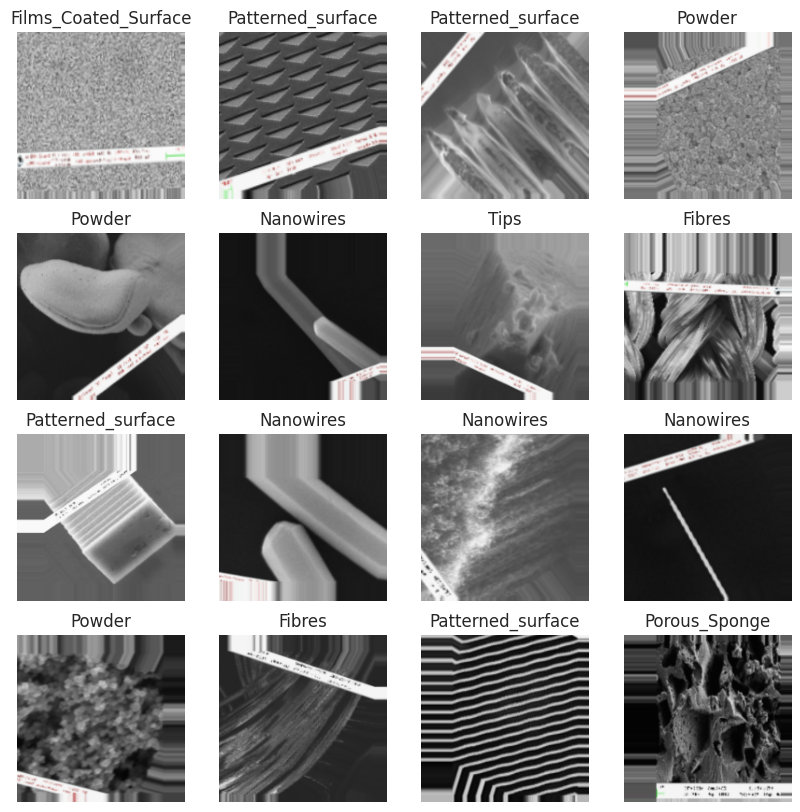

In [ ]:
visualiseDataset(augmentedTrainingDataset, 4, 4)

In [ ]:
#model = Sequential()
#baseModel = Sequential()
['customCNN', 'ResNetTransfer']
if 'customCNN' == useArchitecture:
  model = getBaselineModel(classNames, convolutionKernelRegulariser, convolutionActivityRegulariser)
elif 'ResNetTransfer' == useArchitecture:
  model, baseModel = getTransferLearningModel(classNames, imageHeight, imageWidth, doSeperateFineTuning, makeTransferModelTrainable, addConvolutionLayersOnBaseModel)

234545216/234545216 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D) 

In [ ]:
callbacks = getCallbacks(datasetName, modelName,
                         earlyStoppingMetric, earlyStoppingMinimumImprovementCriterion, earlyStoppingPatience,
                         baselineAccuracy,
                         learningRateReductionMetric, learningRateReductionFactor, patienceForLearningRateReduction,
                         learningRateReductionMinimumImprovementCriterion, learningRateReductionCooldown)



history = model.fit(
  augmentedTrainingDataset,
  validation_data=validationDataset,
  epochs = 200,
  verbose=1,
  callbacks = callbacks
)

saveHistoryAndFinalModel(model, modelSaveLocation, history, historySaveLocation)

Epoch 1/200
31/31 [==============================] - ETA: 0s - loss: 189.7737 - accuracy: 0.1164 - crossentropy: 7.7069
Epoch 1: saving model to /content/drive/My Drive/SEMProject/SEM100/models/allTrainingModels/Resnet_finetunedAfterTraining_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefaultepoch_0001.h5

Epoch 1: val_accuracy did not improve from 0.50000

Epoch 1: val_loss improved from inf to 2.34335, saving model to /content/drive/My Drive/SEMProjectSEM100/models/finalModels/Resnet_finetunedAfterTraining_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefaultLeastLossEpoch_0001.h5
31/31 [==============================] - 87s 2s/step - loss: 189.7737 - accuracy: 0.1164 - crossentropy: 7.7069 - val_loss: 2.3434 - val_accuracy: 0.1066 - val_crossentropy: 9.2568 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - ETA: 0s - loss: 2.3792 - accuracy: 0.1338 - crossentropy: 8.4980
Epoch 2: saving model to /content/drive/My Drive/SEMProject/SEM1

In [ ]:
saveHistoryAndFinalModel(model, modelSaveLocation, history, historySaveLocation)

In [ ]:
with open(historySaveLocation, "rb") as file_pi:
    history = pickle.load(file_pi)

In [ ]:
if doSeperateFineTuning:
  baseModel.trainable = doSeperateFineTuning
  model.summary()

  model.compile(
      optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[keras.metrics.BinaryAccuracy()],
  )

  historyFineTuning = model.fit(augmentedTrainingDataset, validation_data=validationDataset, epochs = 20, verbose = 1, callbacks = callbacks)
  saveHistoryAndFinalModel(model, fineTuneModelSaveLocation, historyFineTuning, fineTuneHistorySaveLocation)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 model (Functional)          (None, 6, 6, 2048)        58331648  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 2048)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 128)         2359

NameError: ignored

In [ ]:
def plotHistory(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['crossentropy'])
  plt.plot(history.history['val_crossentropy'])
  plt.title('model cross entropy')
  plt.ylabel('cross entropy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
def PerformanceReports(confusionMatrix,classificationReport,labels):
    ax= plt.subplot()
    sns.heatmap(confusionMatrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(classificationReport).iloc[:-1, :].T,
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()

In [ ]:
def evaluateModelOnDataset(model, dataset):
  predictedClasses = np.array([])
  trueLabels = np.array([])

  for x, y in dataset:
      predictedClasses = np.concatenate([predictedClasses, np.argmax(model(x), axis=-1)])
      trueLabels = np.concatenate([trueLabels, np.argmax(y.numpy(), axis=-1)])

  confusionMatrix = confusion_matrix(labels= trueLabels, predictions=predictedClasses).numpy()
  classificationReport=classification_report(trueLabels, predictedClasses,
                                      target_names=classNames,
                                      output_dict=True)
  PerformanceReports(confusionMatrix, classificationReport, classNames)

In [ ]:
def evaluatedModel(model):
  scoresTraining = model.evaluate(trainingDataset,verbose=1)
  scoresValidation = model.evaluate(validationDataset,verbose=1)
  scoresTesting = model.evaluate(testingDataset,verbose=1)
  print("Train Accuracy: %.2f%%" % (scoresTraining[1]*100))
  print("Validation Accuracy: %.2f%%" % (scoresValidation[1]*100))
  print("testing Accuracy: %.2f%%" % (scoresTesting[1]*100))

  #print(history.history.keys())
  plotHistory(history)
  if doSeperateFineTuning:
    plotHistory(historyFineTuning)

  evaluateModelOnDataset(model, trainingDataset)
  evaluateModelOnDataset(model, validationDataset)
  evaluateModelOnDataset(model, testingDataset)

In [ ]:
evaluatedModel(model)

In [ ]:
filePath = "/content/drive/MyDrive/SEMProject/SEM100/test/Biological/L7_0349b4595e70ecd793fe0c7785fead38.jpg"

img = tf.keras.utils.load_img(
    filePath, target_size=(imageHeight, imageWidth)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classNames[np.argmax(score)], 100 * np.max(score))
)
